Run the single cell below and then scroll down to the next markdown cell in order to avoid doing the simulation again.

In [1]:
from tqdm import tqdm
import numpy as np
import  matplotlib.pyplot as plt 
plt.style.use('classic')
np.random.seed(1) 

In [2]:
d = 2 # dimension of the input data
n = 20 # Amount of student neurons
k = 15 # Amount of training samples (data)
l = 3 # Amount of teacher neurons

batchsize = 1

In [3]:
def Data(k,d):
    '''Generating k data points on a unit sphere in dimension d.'''
    x = np.random.normal(0,1, (k, d)) 
    x_norm = np.linalg.norm(x, axis = 1) # Euclidean norm

    x = np.transpose(x)/x_norm
    x = np.transpose(x) # (k,d)
    
    return(x)

In [4]:
# Initialisation that is exactly the same as that of Andriushchenko
x = np.array([[ 0.9358, -0.3524],
        [-0.4416, -0.8972],
        [ 0.3520, -0.9360],
        [ 0.9166, -0.3999],
        [ 0.7879, -0.6158],
        [ 0.5788, -0.8155],
        [-0.6430, -0.7659],
        [ 0.7177, -0.6963],
        [-0.1927, -0.9813],
        [ 0.0722,  0.9974],
        [-0.6931,  0.7209],
        [ 0.8735,  0.4868],
        [ 0.7966, -0.6046],
        [-0.1302, -0.9915],
        [-0.4509,  0.8926]]) #Data(k,d)

xtest = Data(1000,d)

w_t = np.array([[-0.9979, -0.0642], # Teacher network of Andriushchenko
        [-0.9325,  0.3611],
        [ 0.9950, -0.1002]])

a_t = np.array([-1., -1.,  1.])

z_t = np.dot(x,np.transpose(w_t)) # (k,d)*(d,l) = (k,l) Inner part of the ReLu
z_t = np.maximum(z_t,0) # (k,l)
h_t = a_t*z_t # (k,l)
y = np.sum(h_t, axis = 1)# k # Teacher output

z_t_test = np.dot(xtest,np.transpose(w_t)) # (k,d)*(d,l) = (k,l) Inner part of the ReLu
z_t_test = np.maximum(z_t_test,0) # (k,l)
h_t_test = a_t*z_t_test # (k,l)
ytest = np.sum(h_t_test, axis = 1)# k # Teacher output

# Student network initialisation of Andriushchenko

a_s = np.array([0., 0., -0., -0., 0., -0., 0., -0., -0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0.])
w_s = np.array([[ 2.9716e-01,  7.7097e-01],
        [ 2.5367e-01, -2.9552e-01],
        [-2.8462e-01,  4.5999e-01],
        [ 5.5541e-01,  6.4494e-01],
        [-7.4796e-01, -9.6919e-02],
        [ 2.2276e-01,  6.6264e-01],
        [-8.1466e-01, -2.7487e-01],
        [-2.3992e-01, -2.4984e-01],
        [-5.6280e-01, -1.5850e-01],
        [-5.4623e-01, -4.2597e-02],
        [-4.6674e-02,  3.4353e-01],
        [-4.1916e-01,  4.4591e-04],
        [-1.3067e+00, -8.4824e-01],
        [-1.1412e-01,  1.3998e-01],
        [ 3.6623e-02,  5.5666e-01],
        [ 1.4113e-01,  2.1711e-01],
        [ 2.2847e-01, -4.3269e-01],
        [ 3.9065e-01, -4.6339e-01],
        [ 1.0321e-01, -1.6672e-01],
        [-2.1441e-01,  1.1646e-01]])

a_s_I = a_s # Store initialisation
w_s_I = w_s
#print(y) # Matches exactly the result of Andriushchenko

In [5]:
# For random initialisation
# Teacher with l neurons
#a_t = np.random.choice([1,-1], l) 

#w_t = np.random.normal(0,1,(l,d))
#w_norm_t = np.linalg.norm(w_t, axis = 1) # l

#w_t = np.transpose(w_t)/w_norm_t # Normalize
#w_t = np.transpose(w_t) # (l,d)

# Student network of n neurons
#init = 0.5
#a_s = np.random.normal(0, init, n) 
#w_s = np.random.normal(0, init, (n,d)) 


In [6]:
def backward(batchsize, S, f_s, y, z_s, d, n, x, a_s, w_s, Index_s, eta):
    '''Backward evaluation of a two layer neural network we return
    the parameters of the network as a result of applying SGD or GD with learning rate eta'''
    
    BatchIndex = np.random.choice(x.shape[0], size=batchsize, replace=False)

    Derivative_L = 2*(f_s-y)/batchsize #S
    
    Derivative_a_s = np.sum(Derivative_L[BatchIndex] * np.transpose(z_s[BatchIndex]), axis = 1)
    
    Derivative_w_s = np.zeros((d,n))
    
    for i in BatchIndex:
         Derivative_w_s += Derivative_L[i]*np.outer(x[i],np.transpose(a_s*Index_s[i]))
    
    w_s = w_s - eta * np.transpose(Derivative_w_s) # GD or SGD
    a_s = a_s - eta * Derivative_a_s
    
    return(w_s, a_s)

In [7]:
def NTK(x, a_s, w_s):
    '''Calculate the rank and Frobenius norm of the neural tangent kernel (NTK)''' 
    z_s = np.dot(x, np.transpose(w_s)) # Inner part of the ReLu
    
    Index_s = z_s >= 0
    z_s = np.maximum(z_s, 0)
    
    NTKw = [np.outer(x[i],np.transpose(a_s*Index_s[i])) for i in range(60)]
    NTKw = np.stack(NTKw)
    #print(NTKw.shape)
    NTKw = np.reshape(NTKw, (60,40))
    
    NTKa = z_s   
    
    NTK = np.concatenate((NTKw,NTKa), axis = 1)
    
    u, s, v = np.linalg.svd(NTK)
    NTKrank = np.sum(s > 1e-10)
    
    return(NTKrank,s)

In [8]:
print(NTK(xtest[:60],a_s_I,w_s_I))

(19, array([7.83719756e+00, 6.28407871e+00, 3.66192468e+00, 1.88776439e+00,
       1.03632872e+00, 3.46209641e-01, 2.18074969e-01, 1.46875175e-01,
       1.10699549e-01, 7.29941465e-02, 4.82969923e-02, 3.99760129e-02,
       3.25392457e-02, 2.26080269e-02, 1.57540696e-02, 1.01648930e-02,
       9.71285544e-03, 6.74764385e-03, 6.68134841e-04, 1.39230539e-15,
       1.26949663e-15, 1.21583166e-15, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
       6.16553210e-16, 6.16553210e-16, 6.16553210e-16, 6.16553210e-16,
 

In [9]:
def forward(x, y, w_s, a_s, S):
    '''Forward evaluation of a two layer neural network,
    in addition to returning the loss we also
    return the in between results as they are nessecary for the backward evaluation'''
    
    z_s = np.dot(x, np.transpose(w_s)) # Inner part of the ReLu
    Index_s = z_s >= 0
    z_s = np.maximum(z_s, 0)
    
    h_s = a_s*z_s 
    f_s = np.sum(h_s, axis = 1)
    
    L = np.mean((f_s-y)**2) # /2

    return(z_s, Index_s, f_s, L)
    

In [10]:
def Training(x, y, xtest, ytest, w_s, a_s, Time, eta, Timedecay, etadecay, batchsize, d, n, k,seed):
    '''Training of a two layer neural network with SGD or GD depending on the batchsize.
    The learning rate is changed from eta to eta/decay when we have reached percentage_decay*steps.
    We return the loss and test loss at each step and the parameters of the resulting network.'''
    
    steps = int(Time/eta)
    stepsdecayed = int(Timedecay/etadecay)
    
    np.random.seed(seed)
    S = len(y)
    
    z_s, Index_s, f_s, L = forward(x, y, w_s, a_s, S)
    Ltest = forward(xtest, ytest, w_s, a_s, len(ytest))[-1]
    
    Loss = []
    TestLoss = []    
    
    NTKrankall = []
    eigenvalues = []
    
    for i in range(steps):
    
        # Backward Pass
        w_s, a_s = backward(batchsize, S, f_s, y, z_s, d, n, x, a_s, w_s, Index_s, eta)

        # Forward Pass
        z_s, Index_s, f_s, L = forward(x, y, w_s, a_s, S)
        
        # Stop if the loss diverges towards infinity
        if L > 10000:
            
            NTKrank, s = NTK(xtest[:60], a_s, w_s)
            NTKrankall.append(NTKrank)
            eigenvalues.append(s)
            
            return(a_s, w_s, Loss, TestLoss, NTKrankall, eigenvalues)
        
        TestLoss.append(forward(xtest, ytest, w_s, a_s, len(ytest))[-1])
        Loss.append(L)    
        
        #if i == int(steps*percentage_decay): # Decreasing the learning rate
    
    for i in range(stepsdecayed):
    
        # Backward Pass
        w_s, a_s = backward(batchsize, S, f_s, y, z_s, d, n, x, a_s, w_s, Index_s, etadecay)

        # Forward Pass
        z_s, Index_s, f_s, L = forward(x, y, w_s, a_s, S)
        
        # Stop if the loss diverges towards infinity
        if L > 10000:
            
            NTKrank, s = NTK(xtest[:60], a_s, w_s)
            NTKrankall.append(NTKrank)
            eigenvalues.append(s)
            
            return(a_s, w_s, Loss, TestLoss, NTKrankall, eigenvalues)
    
        TestLoss.append(forward(xtest, ytest, w_s, a_s, len(ytest))[-1])
        Loss.append(L) 
       
    NTKrank,s = NTK(xtest[:60], a_s, w_s)
    NTKrankall.append(NTKrank)
    eigenvalues.append(s)
    
    return(a_s, w_s, Loss, TestLoss, NTKrankall, eigenvalues)

In [11]:
# We see that around a learning rate 0.4 and 0.45 loss stablilization happens.
itterations = 1000
Time = 1000
eta = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # Learning rates
Timedecay = 100
etadecay = 0.1 # divide the learning rate by this factor when decaying starts
seed = range(1,itterations+1)

Total_Losses = []
Total_Test_Losses = []

Total_NTKrank = []
Total_eigenvalues = []

for j in tqdm(range(itterations)): 
    
    Losses = []
    TestLosses = []
    
    NTKnorms = []
    NTKranks = []
    eigenvalues = []
    for i in range(len(eta)):
        
        a_s_res, w_s_res, Loss, TestLoss, NTKrank, eigen = Training(x, y, xtest, ytest, w_s, a_s, Time, eta[i], Timedecay, etadecay, batchsize, d, n, k, seed[j])
        
        Losses.append(Loss)
        TestLosses.append(TestLoss)
       
        NTKranks.append(NTKrank)
        eigenvalues.append(eigen)
        
    Total_Losses.append(Losses)
    Total_Test_Losses.append(TestLosses)

    Total_NTKrank.append(NTKranks)
    Total_eigenvalues.append(eigenvalues)

100%|██████████| 1000/1000 [2:05:10<00:00,  7.51s/it] 


In [170]:
with open('DataSTnet2tl.npy', 'wb') as f:
    np.save(f, Total_Losses)
    
with open('DataSTnet2ttl.npy', 'wb') as f:
    np.save(f, Total_Test_Losses)

with open('DataSTnet2rank.npy', 'wb') as f:
    np.save(f, Total_NTKrank)
    
with open('DataSTnet2eigen.npy', 'wb') as f:
    np.save(f, Total_eigenvalues)

C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [171]:
eta = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] 
RankLoss = [[],[],[],[],[],[]]

for j in range(len(eta)):
    
    for i in range(itterations):
        
        if Total_Losses[i][j][-1]<0.01:
            
            RankLoss[j].append([Total_Test_Losses[i][j][-1], Total_NTKrank[i][j][-1]])
   

In [172]:
with open('DataSTnet2.npy', 'wb') as f:
    np.save(f, RankLoss)

Run the code below to load the simulation data

In [16]:
# Run from here to avoid doing the simulation again
with open('DataSTnet2tl.npy', 'rb') as f:
    Total_Losses = np.load(f, allow_pickle = True)
    
with open('DataSTnet2ttl.npy', 'rb') as f:
    Total_Test_Losses = np.load(f, allow_pickle = True)

with open('DataSTnet2rank.npy', 'rb') as f:
    Total_NTKrank = np.load(f, allow_pickle = True)
    
with open('DataSTnet2eigen.npy', 'rb') as f:
    Total_eigenvalues = np.load(f, allow_pickle = True)

In [17]:
with open('DataSTnet2.npy', 'rb') as f:
    RankLoss = np.load(f, allow_pickle = True)

In [68]:
itterations = 1000
Time = 1000
eta = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5] # Learning rates
Timedecay = 100
etadecay = 0.1

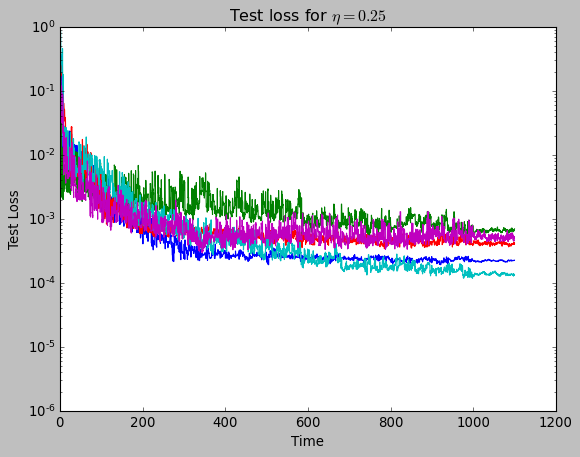

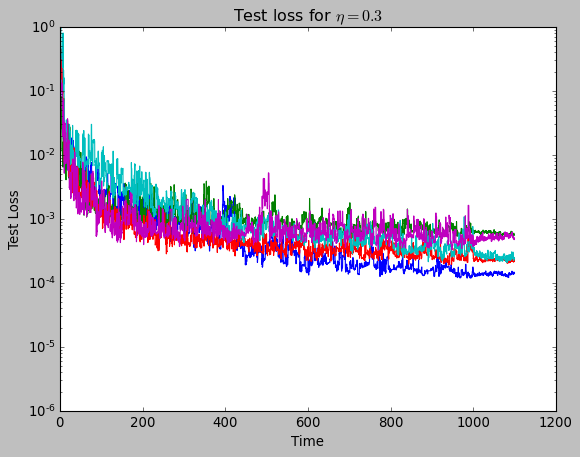

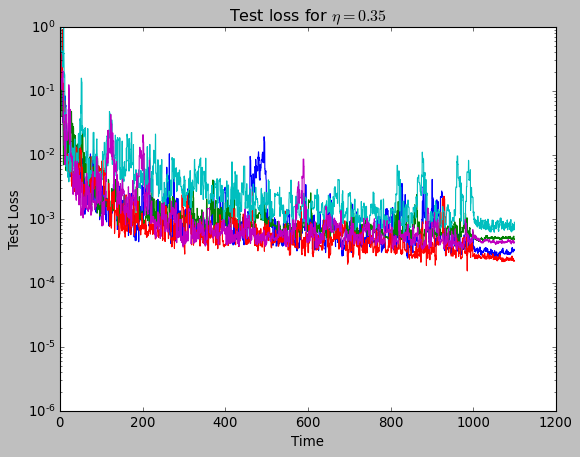

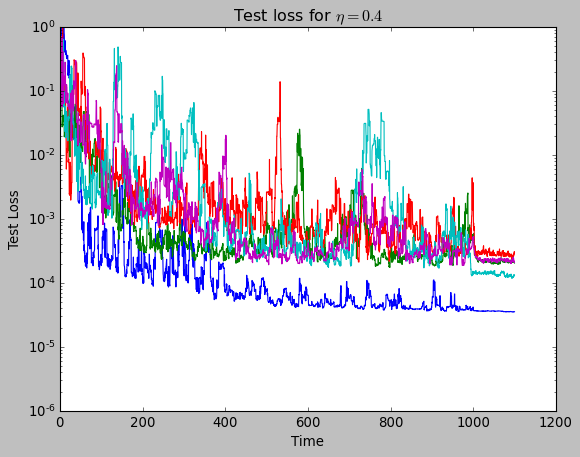

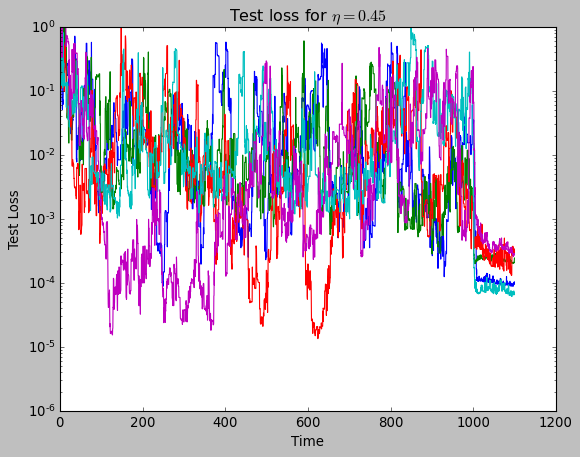

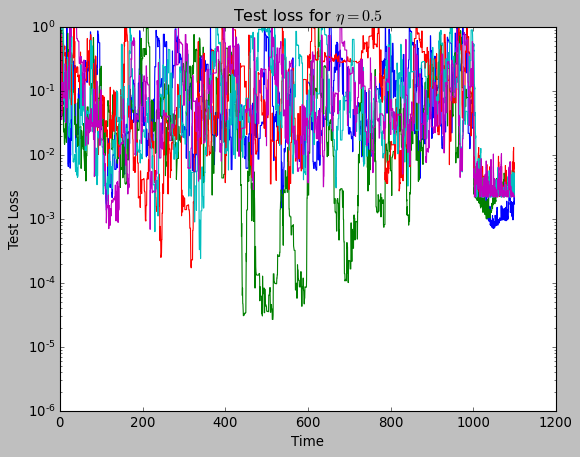

In [79]:
for j in range(len(eta)):
    
    count = 0
    
    for i in range(itterations):
        
        if Total_Losses[i][j][-1]<0.01:
            
            count += 1
            steps = np.arange(0,int(Time),eta[j])
            stepsdecay = np.arange(Time,Time +Timedecay,etadecay)
            
            Totalsteps = np.append(steps,stepsdecay)
            
            if len(Totalsteps) > len(Total_Test_Losses[i][j]):
                
                Totalsteps = Totalsteps[:-1]
                
            plt.plot(Totalsteps,Total_Test_Losses[i][j])
            
            if count > 4:
                
                break
                
    plt.ylim(10e-7,10e-1)
    plt.yscale('log')
    plt.title(f'Test loss for $\eta = {eta[j]}$')
    plt.xlabel('Time')
    plt.ylabel('Test Loss')
 
    plt.savefig(f'TestLossST{eta[j]}.pdf')
 
    plt.show()
    plt.close()

C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\20183166\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


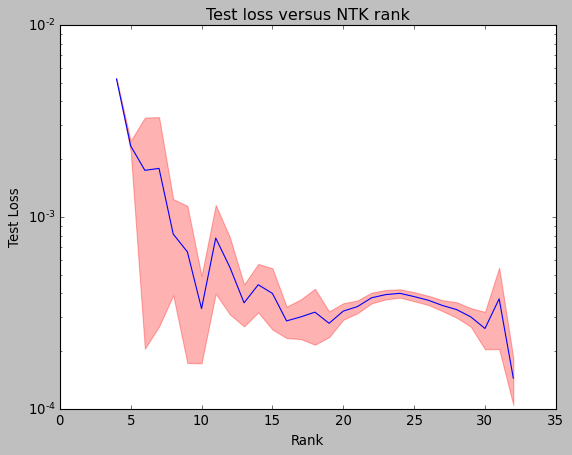

In [53]:
Mean = []
Up = []
Down = []

for j in range(60):
    
    group = []
    
    for i in range(6):
        
        res = np.transpose(np.array(RankLoss[i]))
        
        for k in res[:,res[1] == j][0]:
            
            group.append(k)
     
    Mean.append(np.mean(group))
    Up.append(np.mean(group)+1.96*np.std(group)/np.sqrt(len(group)))
    Down.append(np.mean(group)-1.96*np.std(group)/np.sqrt(len(group)))
       
plt.plot(range(60),Mean)
plt.fill_between(range(60), Down, Up, color='red', alpha=.3)

plt.yscale('log')
plt.xlim(0,35)
plt.ylim(1e-4,1e-2)
plt.title(f'Test loss versus NTK rank')
plt.xlabel('Rank')
plt.ylabel('Test Loss')

plt.savefig(f'TestLossNTKRank.pdf')

plt.show()
plt.close()
  

In [47]:
print(np.mean([(i[1] == 32)*i[0] for i in RankLoss[1]]))

4.340883050932553e-07


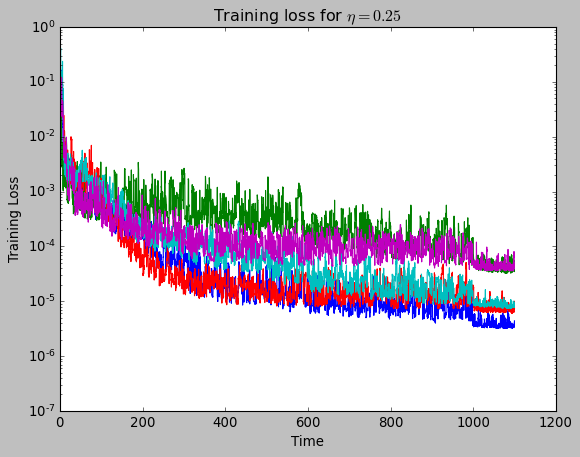

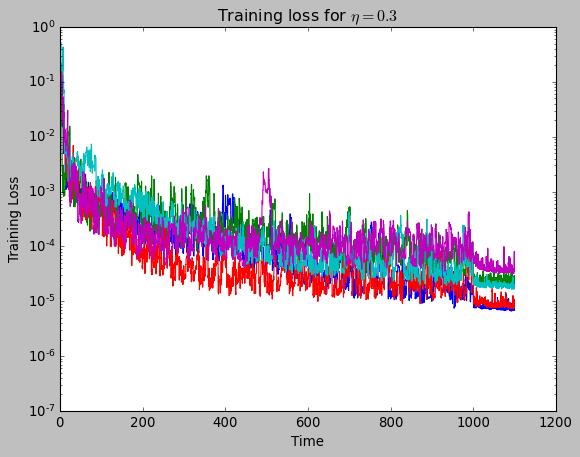

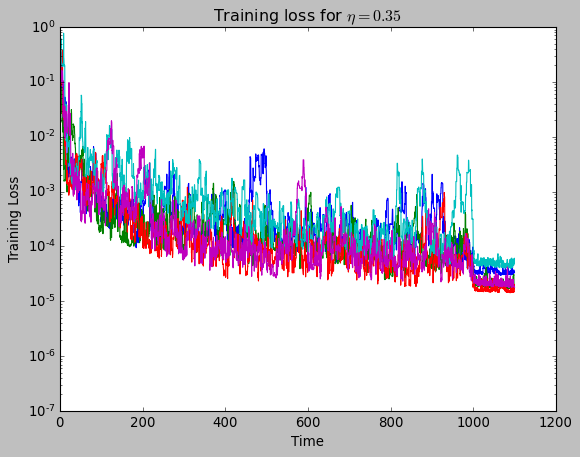

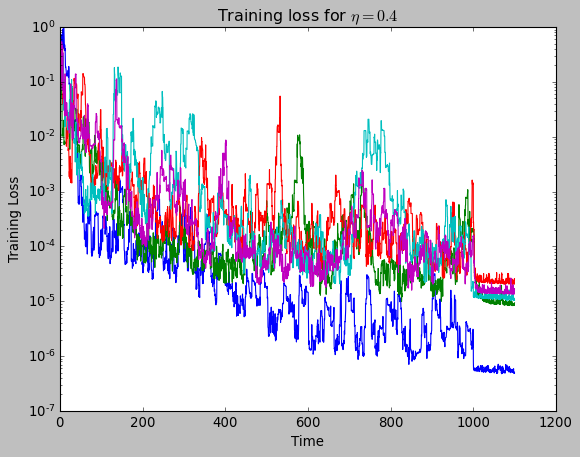

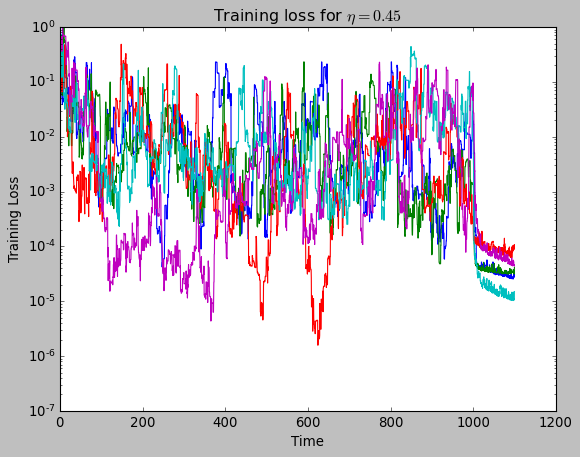

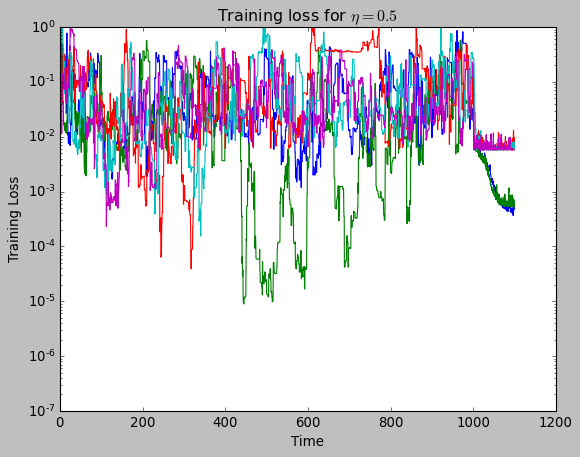

In [78]:
for j in range(len(eta)):
    
    count = 0
    
    for i in range(1000):
        
        if Total_Losses[i][j][-1]<0.01:
            
            count += 1
            steps = np.arange(0,int(Time),eta[j])
            stepsdecay = np.arange(Time,Time +Timedecay,etadecay)
            
            Totalsteps = np.append(steps,stepsdecay)
            
            if len(Totalsteps) > len(Total_Losses[i][j]):
                
                Totalsteps = Totalsteps[:-1]
                
            plt.plot(Totalsteps,Total_Losses[i][j])
            
            if count > 4:
                
                break
                
    plt.ylim(10e-8,10e-1)
    plt.yscale('log')
    plt.title(f'Training loss for $\eta = {eta[j]}$')
    plt.xlabel('Time')
    plt.ylabel('Training Loss')

    plt.savefig(f'StudentTeachertrainRuns{eta[j]}.pdf')

    plt.show()
    plt.close()

In [367]:
for i in range(len(eta)):
    loss = [RankLoss[i][j][0] for j in range(len(RankLoss[i]))]
    print(f'For learning rate {eta[i]}:')
    print(f'The mean test loss:{np.mean(loss)} and the standard deviation: {np.std(loss)}')
    print(f'amount of converged itterations:{len(loss)}')
    
    rank = [RankLoss[i][j][1] for j in range(len(RankLoss[i]))]
    print(f'The mean rank: {np.mean(rank)} and the standard deviation {np.std(rank)}')

For learning rate 0.25:
The mean test loss:0.000456965937318991 and the standard deviation: 0.0002232146881997302
amount of converged itterations:1000
The mean rank: 25.339 and the standard deviation 1.9799189377345732
For learning rate 0.3:
The mean test loss:0.0003730296478198184 and the standard deviation: 0.00019782744334791155
amount of converged itterations:1000
The mean rank: 24.634 and the standard deviation 2.4686117556229856
For learning rate 0.35:
The mean test loss:0.00033795240583283086 and the standard deviation: 0.0002599055473805735
amount of converged itterations:984
The mean rank: 22.617886178861788 and the standard deviation 3.0667249690549747
For learning rate 0.4:
The mean test loss:0.00022759460237431695 and the standard deviation: 0.0002457980845090191
amount of converged itterations:749
The mean rank: 18.55407209612817 and the standard deviation 3.440716710529737
For learning rate 0.45:
The mean test loss:0.00048120282419962155 and the standard deviation: 0.0008

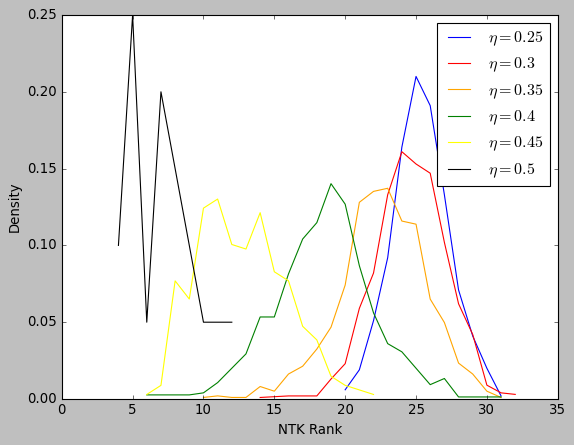

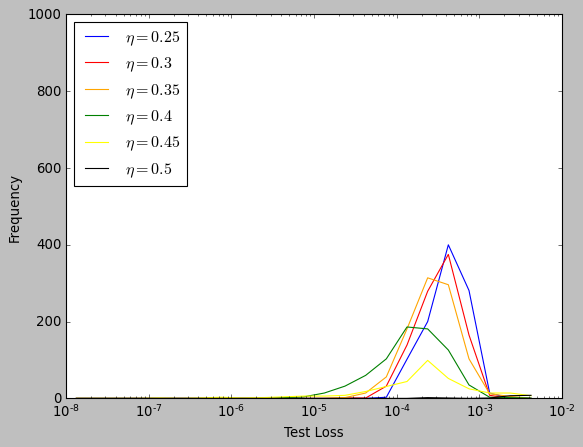

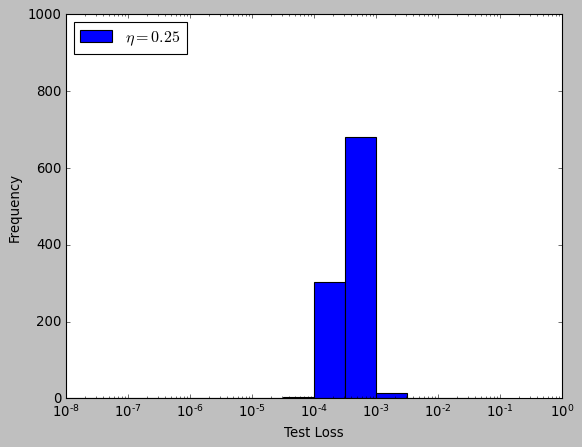

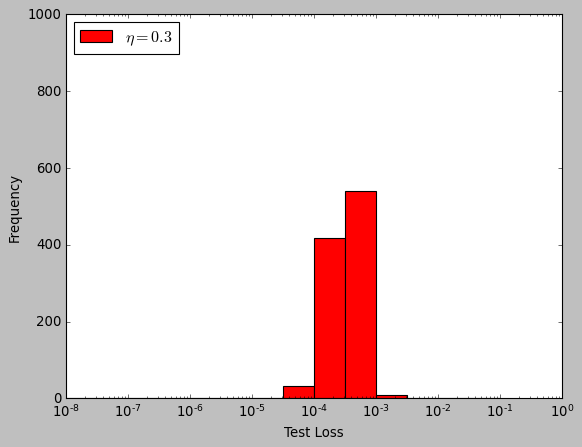

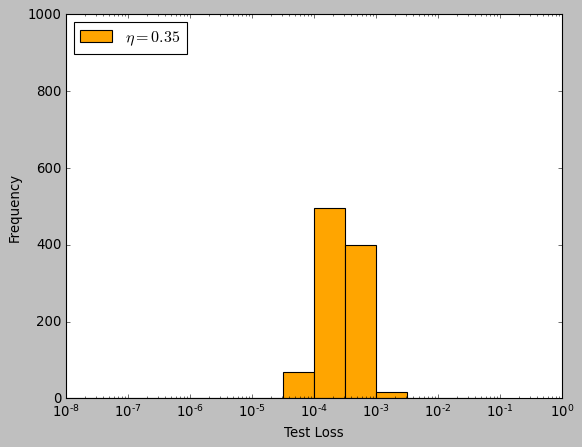

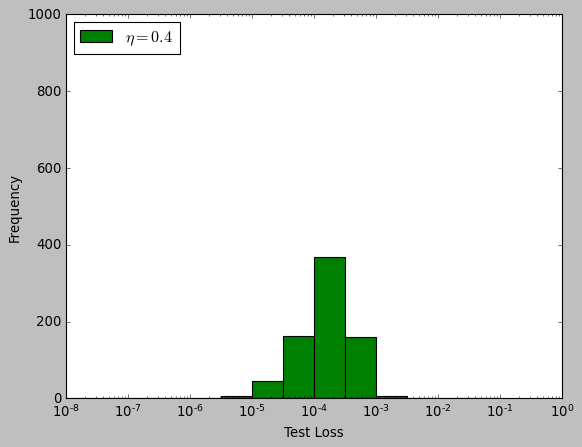

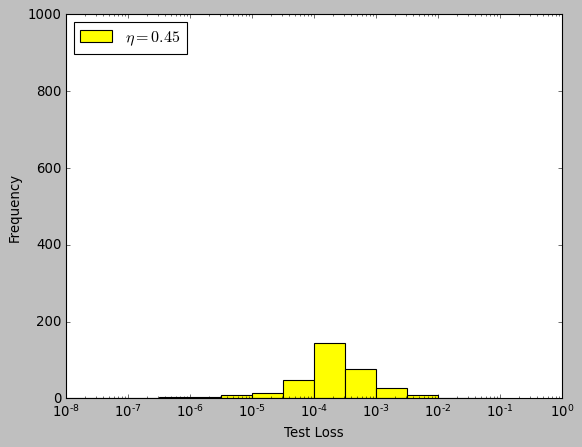

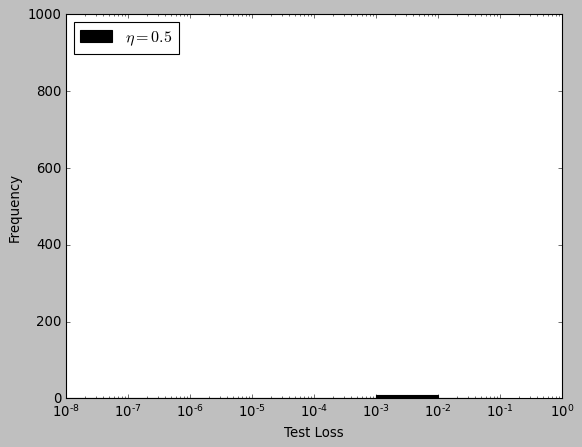

In [72]:
colors = ['blue', 'red', 'orange', 'green','yellow', 'black', 'brown']

for i in range(len(eta)):
    
    res = np.transpose(np.array(RankLoss[i]))        
    res2 = np.unique(res[1], return_counts=True)
    plt.plot(res2[0],res2[1]/len(res[1]),label = f'$\eta = {eta[i]}$', c = colors[i])
    
plt.xlabel('NTK Rank')
plt.ylabel('Density')
plt.legend()

plt.savefig('DensityNTK.pdf')

plt.show()
plt.close()

for i in range(len(eta)):
    res = np.transpose(np.array(RankLoss[i])) 
    b = [10**(-8+ 0.25*i) for i in range(24)]
    hist, binn = np.histogram(res[0], bins = b )
    #print(hist, binn)
    points = [10**(-7.875+0.25*i) for i in range(23)]
    plt.plot(points, hist, label = f'$\eta = {eta[i]}$', c = colors[i])
    #plt.hist(res[0], color = colors[i], alpha =0.9, bins = [1e-10,10**(-9.5),1e-9,10**(-8.5),1e-8,10**(-7.5),1e-7,10**(-6.5),1e-6,10**(-5.5),1e-5,10**(-4.5),1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),1e-1], label = f'learning rate {gamma[i]}')
plt.legend(loc = 2)
plt.xscale('log')
plt.ylim(0,1000)
plt.xlabel('Test Loss')
plt.ylabel('Frequency')
   # plt.title(f'Test loss distribution with decay at {100*percentage_decay[i]}%')
plt.savefig(f'LossDistdecayST.pdf')
plt.show()
plt.close()

for i in range(len(eta)):
    
    res = np.transpose(np.array(RankLoss[i]))        
    plt.hist(res[0], color = colors[i], bins = [1e-8,10**(-7.5),1e-7,10**(-6.5),1e-6,10**(-5.5),1e-5,10**(-4.5),1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),1e-1], label = f'$\eta = {eta[i]}$')
    
    plt.legend(loc =2)
    plt.xscale('log')
    plt.ylim(0,1000)
    plt.xlabel('Test Loss')
    plt.ylabel('Frequency')
   
    plt.savefig(f'LossDistdecayST{eta[i]}.pdf')
    
    plt.show()
    plt.close()

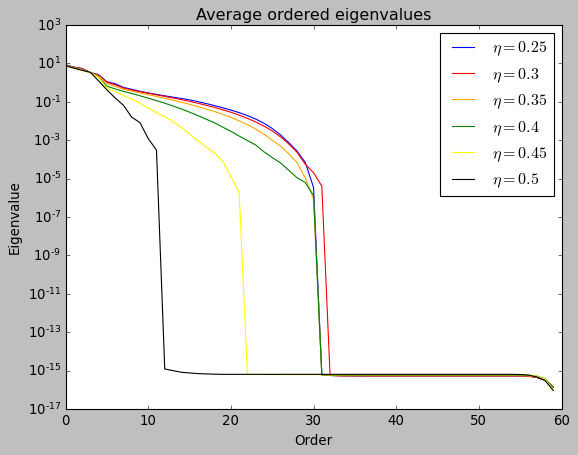

In [75]:
Rankedavg = np.zeros(60)
colors = ['blue', 'red', 'orange', 'green','yellow', 'black']

for j in range(len(eta)):
    Rankedavg = np.zeros(60)
    count = 0
    for i in range(itterations):
        
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            #print(np.array(Total_eigenvalues[i][j][0]))
            Rankedavg += np.array(Total_eigenvalues[i][j][0])
            
    plt.plot(Rankedavg/count, label = f'$\eta = {eta[j]}$', c = colors[j])
    
plt.yscale('log')
plt.xlim(0,60)
plt.ylim(10e-18,10e2)
plt.legend()

plt.xlabel('Order')
plt.ylabel('Eigenvalue')
plt.title(f'Average ordered eigenvalues')

plt.savefig(f'OrderedEigenSTseperate.pdf')
plt.show()
plt.close()

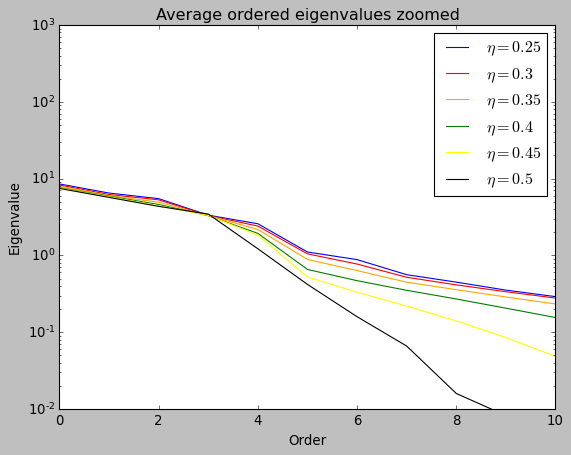

In [76]:
Rankedavg = np.zeros(60)
colors = ['blue', 'red', 'orange', 'green','yellow', 'black']

for j in range(len(eta)):
    Rankedavg = np.zeros(60)
    count = 0
    for i in range(itterations):
        
        if Total_Losses[i][j][-1]<0.01:
            count += 1
            #print(np.array(Total_eigenvalues[i][j][0]))
            Rankedavg += np.array(Total_eigenvalues[i][j][0])
            
    plt.plot(Rankedavg/count, label = f'$\eta = {eta[j]}$', c = colors[j])
    
plt.yscale('log')
plt.xlim(0,10)
plt.ylim(10e-3,10e2)
plt.legend()

plt.xlabel('Order')
plt.ylabel('Eigenvalue')
plt.title(f'Average ordered eigenvalues zoomed')

plt.savefig(f'OrderedEigenSTseperatezoomed.pdf')
plt.show()
plt.close()

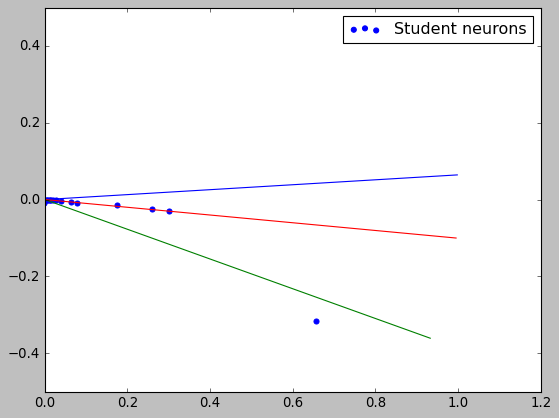

The test loss is 0.00016790527115485753 and the NTK rank is 14


In [168]:
Time = 1000
eta1 = 0.45# Learning rates
Timedecay = 100
etadecay = 0.1 # divide the learning rate by this factor when decaying starts
seed = 26


a_s_res, w_s_res, Loss, TestLoss, NTKrank, eigen = Training(x, y, xtest, ytest, w_s, a_s, Time, eta1, Timedecay, etadecay, batchsize, d, n, k, seed)
        

result = np.transpose(w_s_res)
initialisation =  np.transpose(w_s_I)
    
plt.scatter(a_s_res * result[0], a_s_res * result[1], color = 'blue', label = 'Student neurons')

plt.plot([0,a_t[0] * w_t[0][0]], [0, a_t[0] * w_t[0][1]])
plt.plot([0,a_t[1] * w_t[1][0]], [0,a_t[1] * w_t[1][1]])
plt.plot([0,a_t[2] * w_t[2][0]], [0,a_t[2] * w_t[2][1]])
plt.xlim(0,1.2)
plt.ylim(-0.5,0.5)
plt.legend()
plt.savefig('LowRankBadTest.pdf')
plt.show()
plt.close()
print(f'The test loss is {TestLoss[-1]} and the NTK rank is {NTKrank[0]}')

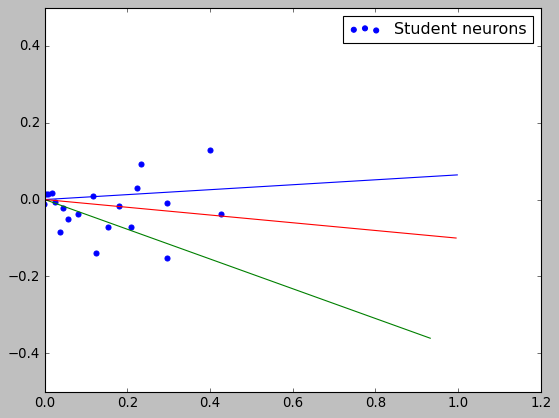

The test loss is 0.00013410127126186155 and the NTK rank is 30


In [169]:
Time = 1000
eta2 = 0.25 # Learning rates
Timedecay = 100
etadecay = 0.1 # divide the learning rate by this factor when decaying starts
seed = 4


a_s_res, w_s_res, Loss, TestLoss, NTKrank, eigen = Training(x, y, xtest, ytest, w_s, a_s, Time, eta2, Timedecay, etadecay, batchsize, d, n, k, seed)
        

result = np.transpose(w_s_res)
initialisation =  np.transpose(w_s_I)
    
plt.scatter(a_s_res * result[0], a_s_res * result[1], color = 'blue',label = 'Student neurons')

plt.plot([0,a_t[0] * w_t[0][0]], [0, a_t[0] * w_t[0][1]])
plt.plot([0,a_t[1] * w_t[1][0]], [0,a_t[1] * w_t[1][1]])
plt.plot([0,a_t[2] * w_t[2][0]], [0,a_t[2] * w_t[2][1]])
plt.xlim(0,1.2)
plt.ylim(-0.5,0.5)
plt.legend()

plt.savefig('HighRankGoodTest.pdf')
plt.show()
plt.close()

print(f'The test loss is {TestLoss[-1]} and the NTK rank is {NTKrank[0]}')